In [1]:
!pip install quantecon

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
import numpy as np
import scipy.linalg as la

In [3]:
# Set parameters
α, β, ρ1, ρ2, σ = 10.0, 0.95, 0.9, 0.0, 1.0

R = 1 / β
A = np.array([[1., 0., 0.],
              [α,  ρ1, ρ2],
              [0., 1., 0.]])
C = np.array([[0.], [σ], [0.]])
G = np.array([[0., 1., 0.]])

# Form LinearStateSpace system and pull off steady state moments
μ_z0 = np.array([[1.0], [0.0], [0.0]])
Σ_z0 = np.zeros((3, 3))
Lz = qe.LinearStateSpace(A, C, G, mu_0=μ_z0, Sigma_0=Σ_z0)
μ_z, μ_y, Σ_z, Σ_y, Σ_yx = Lz.stationary_distributions()

# Mean vector of state for the savings problem
mxo = np.vstack([μ_z, 0.0])

# Create stationary covariance matrix of x -- start everyone off at b=0
a1 = np.zeros((3, 1))
aa = np.hstack([Σ_z, a1])
bb = np.zeros((1, 4))
sxo = np.vstack([aa, bb])

# These choices will initialize the state vector of an individual at zero
# debt and the ergodic distribution of the endowment process. Use these to
# create the Bewley economy.
mxbewley = mxo
sxbewley = sxo

In [4]:
A12 = np.zeros((3,1))
ALQ_l = np.hstack([A, A12])
ALQ_r = np.array([[0, -R, 0, R]])
ALQ = np.vstack([ALQ_l, ALQ_r])

RLQ = np.array([[0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 1e-9]])

QLQ = np.array([1.0])
BLQ = np.array([0., 0., 0., R]).reshape(4,1)
CLQ = np.array([0., σ, 0., 0.]).reshape(4,1)
β_LQ = β

In [5]:
print(f"A = \n {ALQ}")
print(f"B = \n {BLQ}")
print(f"R = \n {RLQ}")
print(f"Q = \n {QLQ}")

A = 
 [[ 1.          0.          0.          0.        ]
 [10.          0.9         0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.         -1.05263158  0.          1.05263158]]
B = 
 [[0.        ]
 [0.        ]
 [0.        ]
 [1.05263158]]
R = 
 [[0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-09]]
Q = 
 [1.]


In [6]:
lqpi = qe.LQ(QLQ, RLQ, ALQ, BLQ, C=CLQ, beta=β_LQ)

In [7]:
P, F, d = lqpi.stationary_values()  # Compute value function and decision rule
ABF = ALQ - BLQ @ F  #  Form closed loop system

In [8]:
# Use the above formulas to create the optimal policies for b_{t+1} and c_t
b_pol = G @ la.inv(np.eye(3, 3) - β * A) @ (A - np.eye(3, 3))
c_pol = (1 - β) * G @ la.inv(np.eye(3, 3) - β * A)

# Create the A matrix for a LinearStateSpace instance
A_LSS1 = np.vstack([A, b_pol])
A_LSS2 = np.eye(4, 1, -3)
A_LSS = np.hstack([A_LSS1, A_LSS2])

# Create the C matrix for LSS methods
C_LSS = np.vstack([C, np.zeros(1)])

# Create the G matrix for LSS methods
G_LSS1 = np.vstack([G, c_pol])
G_LSS2 = np.vstack([np.zeros(1), -(1 - β)])
G_LSS = np.hstack([G_LSS1, G_LSS2])

# Use the following values to start everyone off at b=0, initial incomes zero
μ_0 = np.array([1., 0., 0., 0.])
Σ_0 = np.zeros((4, 4))

In [9]:
ABF - A_LSS

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-9.51248418e-06,  9.51247727e-08,  7.41986086e-17,
        -1.99999901e-08]])

In [10]:
print(c_pol, "\n", -F)

[[6.55172414e+01 3.44827586e-01 3.70993043e-18]] 
 [[ 6.55172323e+01  3.44827677e-01 -0.00000000e+00 -5.00000190e-02]]


In [11]:
lss = qe.LinearStateSpace(A_LSS, C_LSS, G_LSS, mu_0=μ_0, Sigma_0=Σ_0)

In [12]:
def income_consumption_debt_series(A, C, G, μ_0, Σ_0, T=150, npaths=25):
    """
    This function takes initial conditions (μ_0, Σ_0) and uses the
    LinearStateSpace class from QuantEcon to  simulate an economy
    npaths times for T periods. It then uses that information to
    generate some graphs related to the discussion below.
    """
    lss = qe.LinearStateSpace(A, C, G, mu_0=μ_0, Sigma_0=Σ_0)

    # Simulation/Moment Parameters
    moment_generator = lss.moment_sequence()

    # Simulate various paths
    bsim = np.empty((npaths, T))
    csim = np.empty((npaths, T))
    ysim = np.empty((npaths, T))

    for i in range(npaths):
        sims = lss.simulate(T)
        bsim[i, :] = sims[0][-1, :]
        csim[i, :] = sims[1][1, :]
        ysim[i, :] = sims[1][0, :]

    # Get the moments
    cons_mean = np.empty(T)
    cons_var = np.empty(T)
    debt_mean = np.empty(T)
    debt_var = np.empty(T)
    for t in range(T):
        μ_x, μ_y, Σ_x, Σ_y = next(moment_generator)
        cons_mean[t], cons_var[t] = μ_y[1], Σ_y[1, 1]
        debt_mean[t], debt_var[t] = μ_x[3], Σ_x[3, 3]

    return bsim, csim, ysim, cons_mean, cons_var, debt_mean, debt_var

def consumption_income_debt_figure(bsim, csim, ysim):

    # Get T
    T =  bsim.shape[1]

    # Create the first figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Plot consumption and income
    ax[0].plot(csim[0, :], label="c", color="b")
    ax[0].plot(ysim[0, :], label="y", color="g")
    ax[0].plot(csim.T, alpha=.1, color="b")
    ax[0].plot(ysim.T, alpha=.1, color="g")
    ax[0].legend(loc=4)
    ax[0].set(title="Nonfinancial Income, Consumption, and Debt",
              xlabel="t", ylabel="y and c")

    # Plot debt
    ax[1].plot(bsim[0, :], label="b", color="r")
    ax[1].plot(bsim.T, alpha=.1, color="r")
    ax[1].legend(loc=4)
    ax[1].set(xlabel="t", ylabel="debt")

    fig.tight_layout()
    return fig

def consumption_debt_fanchart(csim, cons_mean, cons_var,
                              bsim, debt_mean, debt_var):
    # Get T
    T =  bsim.shape[1]

    # Create percentiles of cross-section distributions
    cmean = np.mean(cons_mean)
    c90 = 1.65 * np.sqrt(cons_var)
    c95 = 1.96 * np.sqrt(cons_var)
    c_perc_95p, c_perc_95m = cons_mean + c95, cons_mean - c95
    c_perc_90p, c_perc_90m = cons_mean + c90, cons_mean - c90

    # Create percentiles of cross-section distributions
    dmean = np.mean(debt_mean)
    d90 = 1.65 * np.sqrt(debt_var)
    d95 = 1.96 * np.sqrt(debt_var)
    d_perc_95p, d_perc_95m = debt_mean + d95, debt_mean - d95
    d_perc_90p, d_perc_90m = debt_mean + d90, debt_mean - d90


    # Create second figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Consumption fan
    ax[0].plot(xvals, cons_mean, color="k")
    ax[0].plot(csim.T, color="k", alpha=.25)
    ax[0].fill_between(xvals, c_perc_95m, c_perc_95p, alpha=.25, color="b")
    ax[0].fill_between(xvals, c_perc_90m, c_perc_90p, alpha=.25, color="r")
    ax[0].set(title="Consumption/Debt over time",
              ylim=(cmean-15, cmean+15), ylabel="consumption")

    # Debt fan
    ax[1].plot(xvals, debt_mean, color="k")
    ax[1].plot(bsim.T, color="k", alpha=.25)
    ax[1].fill_between(xvals, d_perc_95m, d_perc_95p, alpha=.25, color="b")
    ax[1].fill_between(xvals, d_perc_90m, d_perc_90p, alpha=.25, color="r")
    ax[1].set(xlabel="t", ylabel="debt")

    fig.tight_layout()
    return fig

/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_58006/353008971.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cons_mean[t], cons_var[t] = μ_y[1], Σ_y[1, 1]
/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_58006/353008971.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  debt_mean[t], debt_var[t] = μ_x[3], Σ_x[3, 3]


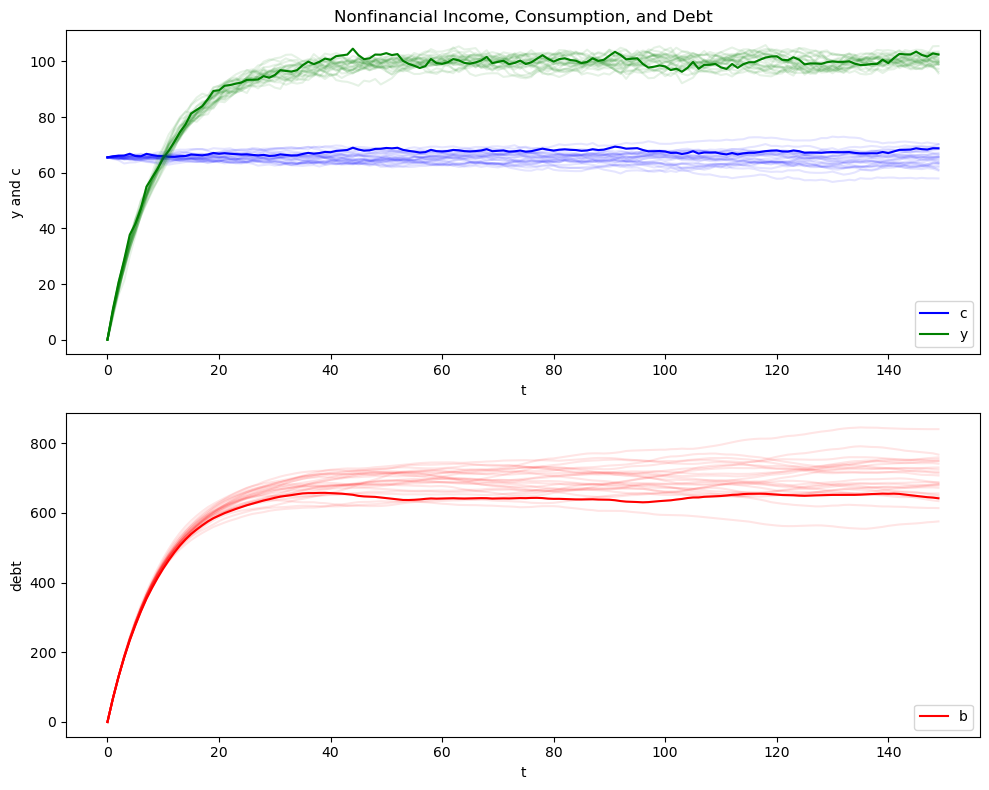

In [13]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, μ_0, Σ_0)
bsim0, csim0, ysim0 = out[:3]
cons_mean0, cons_var0, debt_mean0, debt_var0 = out[3:]

consumption_income_debt_figure(bsim0, csim0, ysim0)

plt.show()

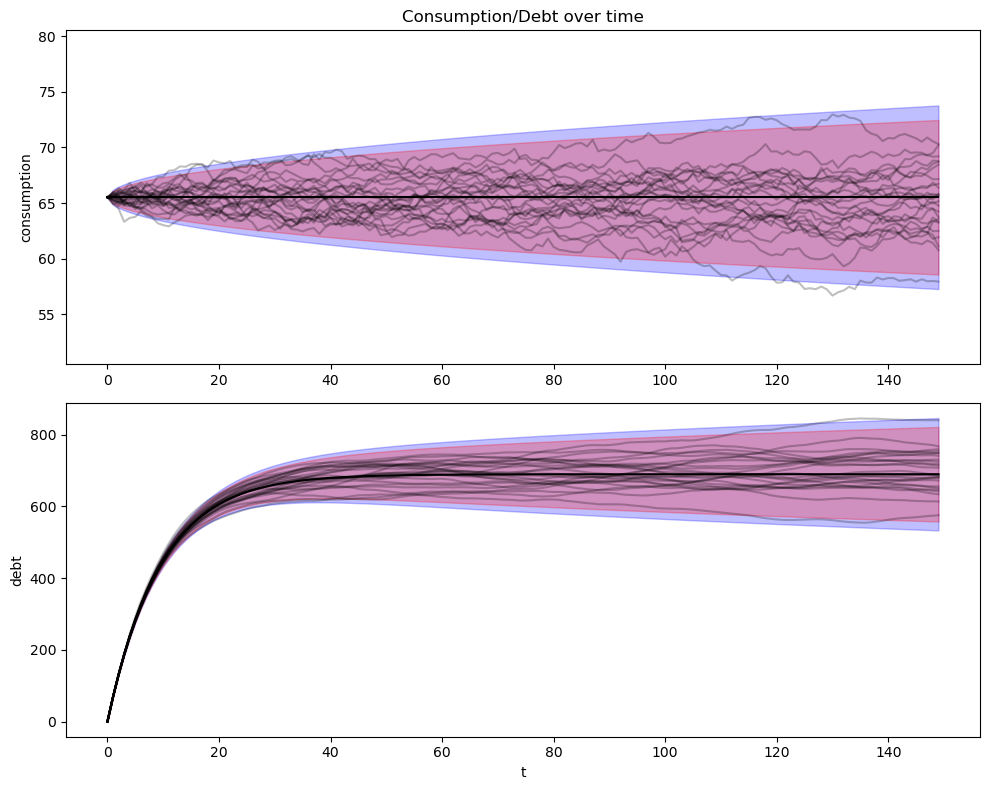

In [14]:
consumption_debt_fanchart(csim0, cons_mean0, cons_var0,
                          bsim0, debt_mean0, debt_var0)

plt.show()

In [15]:
def cointegration_figure(bsim, csim):
    """
    Plots the cointegration
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot((1 - β) * bsim[0, :] + csim[0, :], color="k")
    ax.plot((1 - β) * bsim.T + csim.T, color="k", alpha=.1)

    ax.set(title="Cointegration of Assets and Consumption", xlabel="t")

    return fig

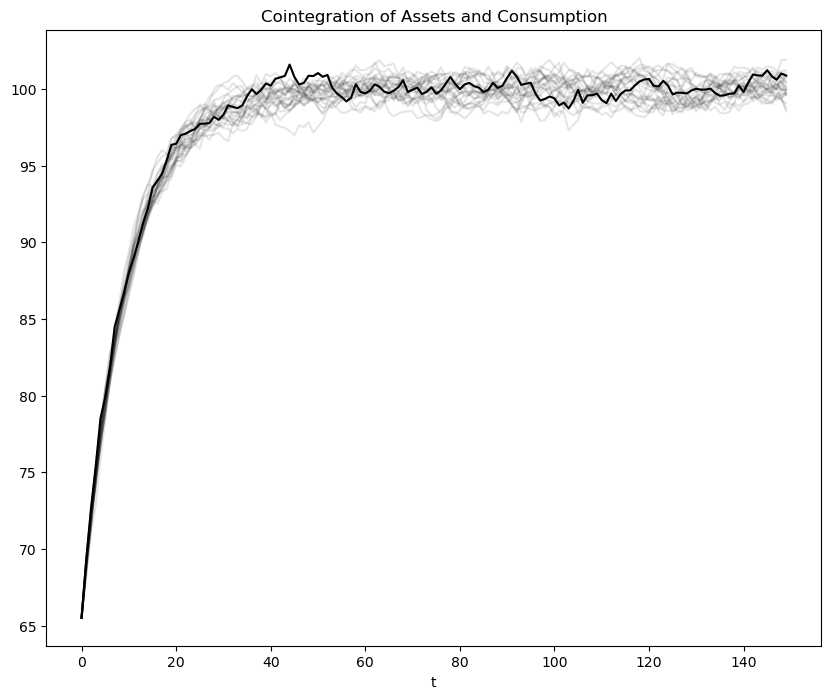

In [16]:
cointegration_figure(bsim0, csim0)
plt.show()

/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_58006/353008971.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cons_mean[t], cons_var[t] = μ_y[1], Σ_y[1, 1]
/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_58006/353008971.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  debt_mean[t], debt_var[t] = μ_x[3], Σ_x[3, 3]


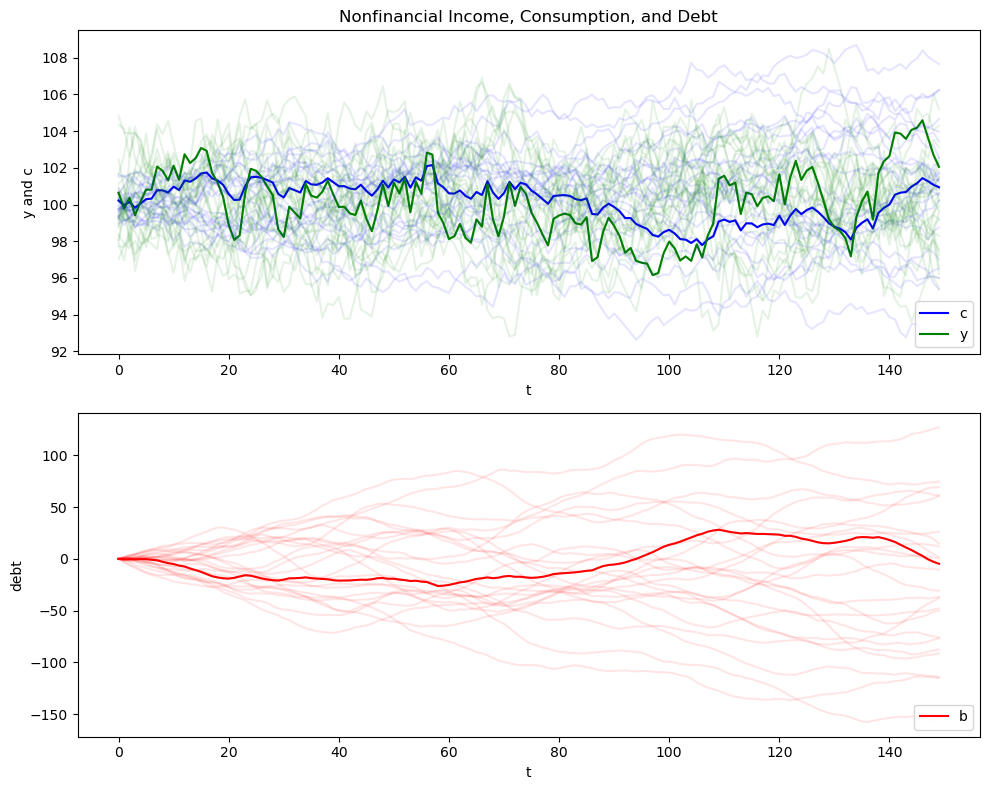

In [17]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, mxbewley, sxbewley)
bsimb, csimb, ysimb = out[:3]
cons_meanb, cons_varb, debt_meanb, debt_varb = out[3:]

consumption_income_debt_figure(bsimb, csimb, ysimb)

plt.show()

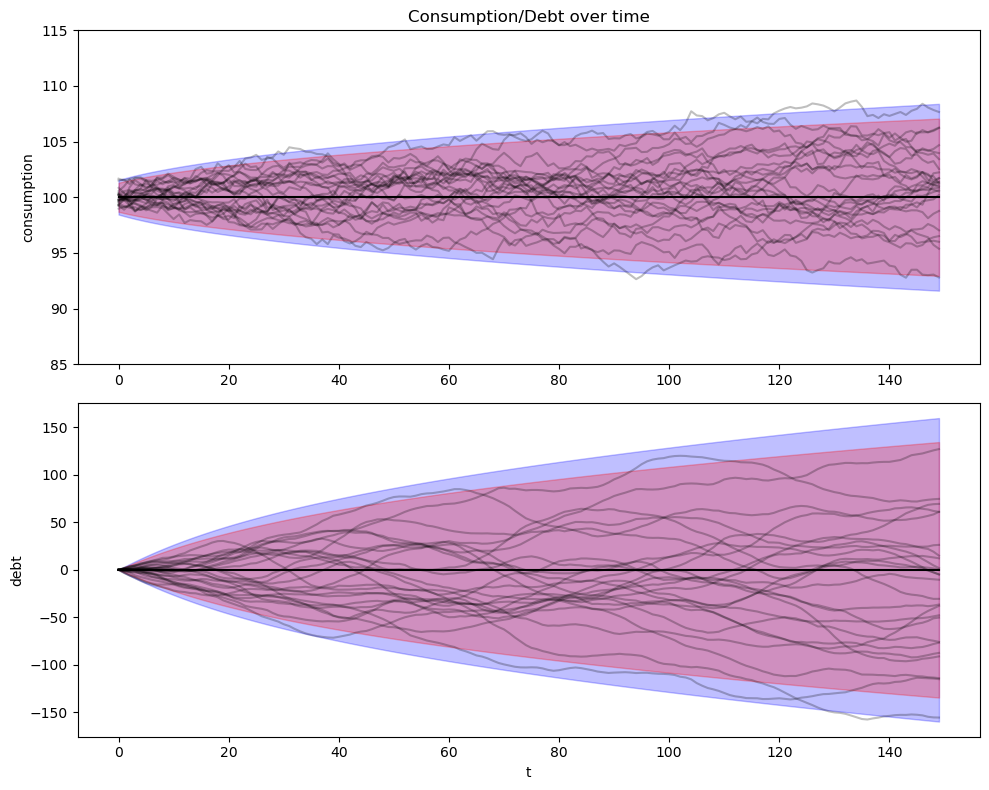

In [18]:
consumption_debt_fanchart(csimb, cons_meanb, cons_varb,
                          bsimb, debt_meanb, debt_varb)

plt.show()

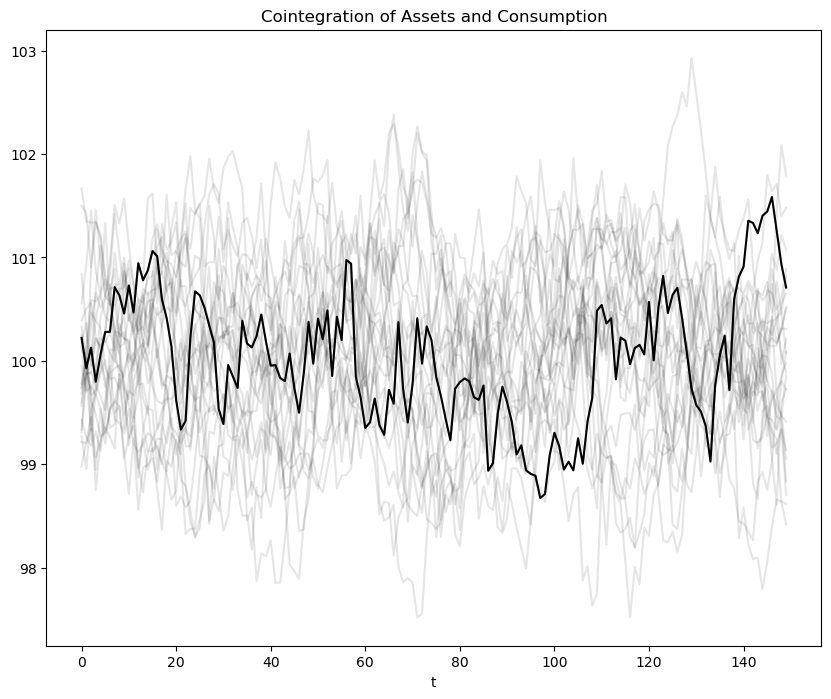

In [19]:
cointegration_figure(bsimb, csimb)
plt.show()